<a href="https://colab.research.google.com/github/yahito/ml-skillbox/blob/master/%D0%A1%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_Curr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2022-06-05 15:15:40--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.135.145
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.135.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.1MB/s    in 7m 2s   

2022-06-05 15:22:42 (43.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-06-05 15:22:43--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.130.73
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.130.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  46.4MB/s    in 17s     

2022-06-05 15:23:00 (44.7 MB/s) - 

### Импорт необходимых библиотек

In [7]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.2


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8) # Wraps a python function into a TensorFlow op that executes it eagerly.
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list)) # Randomly shuffles the elements of this dataset.
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs) # Repeats this dataset so each original value is seen count times.
        dataset = dataset.batch(batch_size, drop_remainder=True) # Combines consecutive elements of this dataset into batches of size batch_size (if drop_remainder == True only full batches)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')



#train_ds = COCO_dataset_train.train_dataset(...)
#val_ds = COCO_dataset_val.val_dataset(...)

loading annotations into memory...
Done (t=17.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [ ]:
ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_train2017.json')

coco = COCO(ann_file_fpath)


loading annotations into memory...
Done (t=19.31s)
creating index...
index created!


In [ ]:
print(coco.getCatIds())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

ann_ids = coco.getAnnIds(iscrowd=False)
anns = coco.loadAnns(ann_ids)
anns = [ann for ann in anns if len(ann['segmentation']) > 1]
print("num of annotations with more than one polygan:", len(anns))    # 3522
coco_dataset_path = "./data/"
cats = coco.getCatIds()

cats = coco.getCatIds(catNms=['person'])

for i in range(101, 102):
    ann = anns[i]
    print(print(ann.keys()))
    image_id = ann["image_id"]
    segs = ann["segmentation"]
    print(f'category_id: {ann["category_id"]}')
    bbox = np.array(ann["bbox"])
    bbox[2:4] = bbox[0:2] + bbox[2:4]
    print("BBox[{}] (xyxy):".format(i), bbox.tolist())

    image_info = coco.loadImgs(image_id)
    image_path = image_info[0]["file_name"]
    # [0] is required, always return a list
    image_path = os.path.join(coco_dataset_path, "train2017", image_path)

    print(image_path)
    # /export/public/MS-COCO-2017/val2017/000000061108.jpg

    image = cv2.imread(image_path)
    segs = [np.array(seg, np.int32).reshape((1, -1, 2))
            for seg in segs]

    print(len(image_info))
    print(image_info[0]['id'])

    cats = (ann["category_id"])
    ann_ids = coco.getAnnIds(imgIds=image_info[0]['id'], catIds=cats, iscrowd=None)
    print(f'ann {type(ann)}')
    anns1 = coco.loadAnns(ann_ids)
    print(f'anns1 {type(anns1)} {len(anns1)} {anns1}')

    mask_class = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    mask_class += coco.annToMask(ann)
    mask_class = (mask_class > 0).astype(np.uint8)


    mask = coco.annToMask(anns1[0])
    for i in range(len(anns1)):
        mask += coco.annToMask(anns1[i])

    print(mask.shape)
    print(type(mask[0][0]))
  
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))
    for c in contours:
        cv2.drawContours(image, c, -1, (0,255,0), 2)

    cv2_imshow(image)


NameError: ignored

In [3]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()


loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)
model.build([None, 256, 256, 3])



In [ ]:
# batch_size, epochs, inp_size

train = COCO_dataset_train.train_dataset(10, 1, 256)
val = COCO_dataset_val.val_dataset(10, 256)
print(train)


history = model.fit(train, validation_data = val, epochs=2)

<BatchDataset element_spec=(TensorSpec(shape=(10, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(10, 256, 256, None), dtype=tf.float32, name=None))>
Epoch 1/2
6411/6411 [==============================] - 1785s 278ms/step - loss: 0.2245 - val_loss: 0.2315
Epoch 2/2
6411/6411 [==============================] - 1783s 278ms/step - loss: 0.2196 - val_loss: 0.2327


In [4]:
from tensorflow import keras
#model.save_weights('my_model_weights-l.h5')

model_loaded = ASPPNet()
loss_2 = tf.keras.losses.BinaryCrossentropy()
model_loaded.compile(optimizer='adam', loss=loss_2)
model_loaded.build([None, 256, 256, 3])
model_loaded.load_weights('my_model_weights (3).h5')

#from tensorflow import keras
#model = keras.models.load_model('data/model-new-2', custom_objects={'aspp': ASPPBlock, 'aspp_net': ASPPNet})
#model_loaded = keras.models.load_model('model-5.tf')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(575, 1024)
<class 'numpy.uint8'>


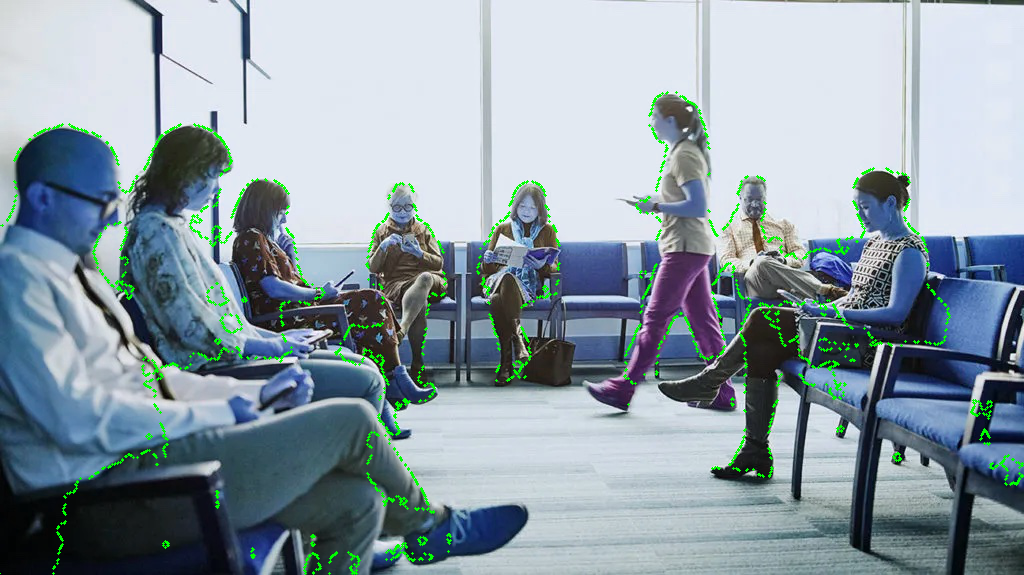

In [9]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

img_x = io.imread('GettyImages-1211642701_header-1024x575.jpeg')
img = tf.cast(img_x, tf.float32) / np.float32(255.)
s = img[None, ...]

mask = model_loaded.predict(s)
f = mask[0]

s = (f > 0.3).astype(np.uint8)

print(s[:, :, 0].shape)
print(type(s[:, :, 0][0][0]))

contours, hierarchy = cv2.findContours(s[:, :, 0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))
for c in contours:
    cv2.drawContours(img_x, c, -1, (0,255,0), 2)

cv2_imshow(img_x)

